# Lesson 6 | Binary Splits & Becoming a Kaggle Gangster
> Random Forests are Amazing, Learn to Crush Kaggle Comps

> Checkout this notebook in [colab](https://colab.research.google.com/github/nglillywhite/blog/blob/main/posts/2023-01-24%20Fastai%20Lesson%206.ipynb)

## Lecture Content

### Prepping Titanic Data

First we'll grab the titanic data like we did last lesson and pre process the data as we did before

In [1]:
from fastai.imports import *

In [2]:
path = Path("../data/titanic/")

df = pd.read_csv(path/'train.csv')
test_df = pd.read_csv(path/"test.csv")
modes = df.mode().iloc[0]

The other thing we'll do differently is utilise pandas to convert a categorical variable to a categorical data type which will handle the encoding for us by creating a vocab in the backend but displaying us the text data we're used to

In [3]:
def process_titanic(df):
    df["Fare"] = df.Fare.fillna(0)
    df.fillna(modes, inplace=True)
    df["LogFare"] = np.log1p(df["Fare"])
    df["Embarked"] = pd.Categorical(df.Embarked)
    df["Sex"] = pd.Categorical(df.Sex)
    
process_titanic(df)
process_titanic(test_df)

In [4]:
categorical_columns = ["Sex", "Embarked"]
continuous_columns = ["Age", "SibSp", "Parch", "LogFare", "Pclass"]
dependent = "Survived"

To illustrate the pandas vocab --> numbers vocab explanation, lets check quickly the "Sex" column and then see the corresponding .cat.codes attribute which houses the matching values

In [5]:
df.Sex.head(), df.Sex.cat.codes.head()

(0      male
 1    female
 2    female
 3    female
 4      male
 Name: Sex, dtype: category
 Categories (2, object): ['female', 'male'],
 0    1
 1    0
 2    0
 3    0
 4    1
 dtype: int8)

And you can see that male = 1, female = 0, as well as seeing the categories in the vocab list which in this case only includes two.

### Binary Splits

We're going to work our way up to Gradient Boosted Machines and Random Forests but in order to do that we have to be able to create decision trees and these are made of binary splits. We know where we're heading, lets now go from the bottom up and construct our way to gradient boosting.

A binary split is simply a rule where all the data is placed into one of two groups based on some threshold, hence binary, group 0 or 1. In our situation using the above "Sex" column, we could split males and females into two groups by thresholding the rows above or below `0.5`. Lets first have a look at the data visually to see what a split like this might perform like.

[Text(0.5, 1.0, 'Histogram')]

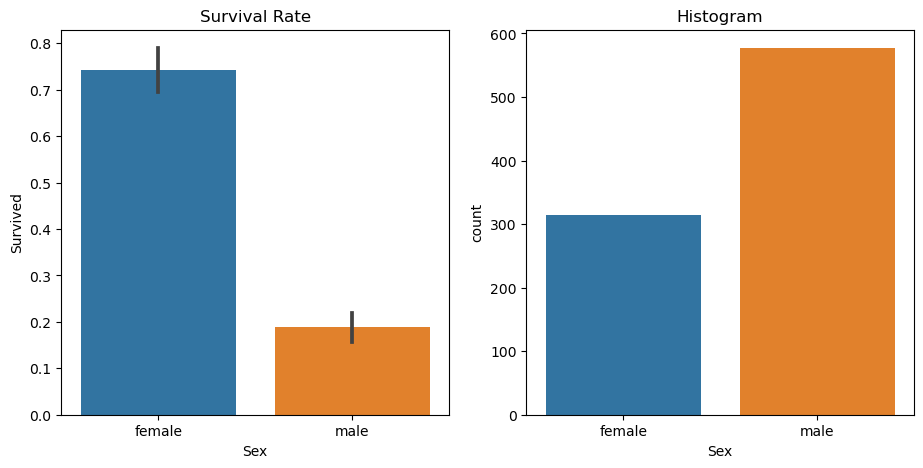

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1,2,figsize=(11,5))
sns.barplot(data=df,
            y=dependent,
            x="Sex",
            ax=axs[0]).set(title="Survival Rate")
sns.countplot(data=df,
             x="Sex",
             ax=axs[1]).set(title="Histogram")

The survival rate differences for males and females are starkly different, females have over triple the survival rate of males so if we used our binary split, we wouldn't actually perform too badly! Lets test that out just for illustration.

Lets setup a train and validation dataset as well as convert our categorical attributes back to numerical codes which we can do with lambda.

In [7]:
from numpy import random
from sklearn.model_selection import train_test_split

random.seed(27)
train_df, validation_df = train_test_split(df, test_size=0.25)
train_df[categorical_columns] = train_df[categorical_columns].apply(lambda x: x.cat.codes)
validation_df[categorical_columns] = validation_df[categorical_columns].apply(lambda x: x.cat.codes)

Lets now make our 'y' / dependent variable and our 'x's or independent variable

In [8]:
def xs_y(df):
    xs = df[categorical_columns+continuous_columns].copy()
    return xs, df[dependent] if dependent in df else None

train_xs, train_y = xs_y(train_df)
validation_xs, validation_y = xs_y(validation_df)

Now lets predict using our binary split, where all males die and all females live

In [9]:
preds = validation_xs.Sex == 0

Lets use mean absolute error which we've used in previous lessons to test our performance

In [10]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(validation_y, preds)

0.242152466367713

Now we've used a categorical column to split which has very strong delineation between values but we can do this with continues variables as well. Lets visualise LogFare and try and pick a good threshold, we're going to use slightly different visualisations because the data is continues. We can however have a very similar view, we can use a boxplot / boxenplot (more quantiles/partitions) and a kernel density plot which will bucket our continues value into tiny little buckets and then histogram those buckets to produce a similar effect as a histogram. Lets have a look

<AxesSubplot: xlabel='LogFare', ylabel='Density'>

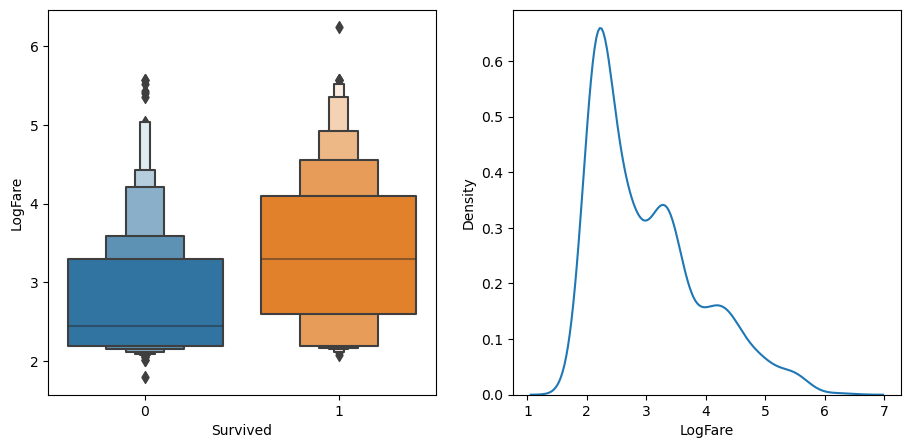

In [11]:
df_fare = train_df[train_df.LogFare>0]

fig,axs = plt.subplots(1,2,figsize=(11,5))
sns.boxenplot(data=df_fare, x=dependent, y="LogFare",ax=axs[0])
sns.kdeplot(data=df_fare, x="LogFare",ax=axs[1])

If we checkout the boxenplot on the left, we can see the average logfare of not surviving is about 2.5, for those that lived, its about 3.2, if you paid more for a ticket, you were more likely to survive, go figure.

Lets make another model based on this split

In [12]:
preds = validation_xs.LogFare > 2.7
mean_absolute_error(validation_y, preds)

0.40358744394618834

Almost twice as bad as the split by Sex...

Lets now write a way to test more columns and more thresholds, we'll first write a scoring function to return how good our splits are so that we can compare them to others quickly. We're also going to introduce the concept of 'impurity' to each group in the sense that after we've split a group, we want all the rows of the group to be like the rest of them, we'd like 'pure' groups.

We can measure this similarity / purity by taking the standard deviation of the dependent variable, the larger this value is, the more different the rows are to each other, we'll then multiply this score by the value of the rows to punish larger groups of equal purity.

In [13]:
def side_score(side, y):
    total = side.sum()
    if total<=1: return 0
    return y[side].std()*total

This will give us a score for a particular 'side' or group, lets now calculate the score for a particular split by adding up the total score of both sides

In [14]:
def score(column, y, split):
    lhs = column<=split
    return (side_score(lhs,y) + side_score(~lhs,y))/len(y)

Also the '~' operator we discussed in previous lessons, I won't repeat the docs or explanation here, try see if you can find it in my blog!

Lets test it out on our first split by Sex and see the 'impurity' score

In [15]:
score(train_xs["Sex"], train_y, 0.5)

0.40174577324058475

Now lets try LogFare again

In [16]:
score(train_xs["LogFare"], train_y, 2.7)

0.4670131181830465

Great, not quite the same difference in magnitude of error but our "Sex" split is far more effective than our LogFare split.

Lets muck around with an interactive version, excuse this if you're reading in quarto, checkout the colab notebook link at the top if you'd like to play around, otherwise I may come back and create an altair tool to play with at a later date.

In [17]:
def iscore(name, split):
    column = train_xs[name]
    return score(column, train_y, split)
    
from ipywidgets import interact
interact(name=continuous_columns, split=15.15)(iscore)

interactive(children=(Dropdown(description='name', options=('Age', 'SibSp', 'Parch', 'LogFare', 'Pclass'), val…

<function __main__.iscore(name, split)>

In [18]:
interact(name=categorical_columns, split=2)(iscore)

interactive(children=(Dropdown(description='name', options=('Sex', 'Embarked'), value='Sex'), IntSlider(value=…

<function __main__.iscore(name, split)>

Similar to playing around with the fit function from the earlier lessons, this hammers home the point of finding the lowest loss but its finicky when manual like this, lets automatically find the best splits by looking at all the possibly splits we could do and find the best loss. Lets try it with Age

In [19]:
name = "Age"
column = train_xs[name]
unique = column.unique()
unique.sort()
unique

array([ 0.67,  0.75,  0.83,  1.  ,  2.  ,  3.  ,  4.  ,  5.  ,  6.  ,
        7.  ,  8.  ,  9.  , 10.  , 11.  , 12.  , 13.  , 14.  , 14.5 ,
       15.  , 16.  , 17.  , 18.  , 19.  , 20.  , 20.5 , 21.  , 22.  ,
       23.  , 24.  , 24.5 , 25.  , 26.  , 27.  , 28.  , 28.5 , 29.  ,
       30.  , 30.5 , 31.  , 32.  , 32.5 , 33.  , 34.  , 35.  , 36.  ,
       37.  , 38.  , 39.  , 40.  , 40.5 , 41.  , 42.  , 43.  , 44.  ,
       45.  , 45.5 , 46.  , 47.  , 48.  , 49.  , 50.  , 51.  , 52.  ,
       53.  , 54.  , 55.  , 55.5 , 56.  , 57.  , 58.  , 59.  , 60.  ,
       61.  , 62.  , 63.  , 64.  , 65.  , 66.  , 70.  , 70.5 , 71.  ,
       74.  , 80.  ])

This gives us all the possible Age values we could use, lets checkout the scores

In [20]:
scores = np.array([score(column,train_y,o) for o in unique if not np.isnan(o)])
f"Optimal Age Split is {unique[scores.argmin()]}", f"Optimal Age Split Index is {scores.argmin()}", f"Scores are ",scores

('Optimal Age Split is 1.0',
 'Optimal Age Split Index is 3',
 'Scores are ',
 array([0.48594849, 0.48404762, 0.48213925, 0.48022329, 0.48618568,
        0.4850268 , 0.48466283, 0.4829376 , 0.48298419, 0.48345047,
        0.48304092, 0.48346219, 0.48417261, 0.4841437 , 0.48378607,
        0.48303173, 0.48299166, 0.48333772, 0.4821711 , 0.48240352,
        0.48284921, 0.48367573, 0.48462972, 0.48557444, 0.48570274,
        0.48645229, 0.48610302, 0.48649283, 0.48693277, 0.48688775,
        0.48647636, 0.48628599, 0.48690896, 0.48683546, 0.48672752,
        0.48675081, 0.4867205 , 0.48659482, 0.48699805, 0.48715547,
        0.48717052, 0.4871025 , 0.48723429, 0.4872322 , 0.48710254,
        0.48719272, 0.48709139, 0.48714029, 0.48699734, 0.48704597,
        0.48707436, 0.48714085, 0.48715271, 0.48720485, 0.48718624,
        0.4872376 , 0.48726382, 0.48723709, 0.4871586 , 0.48698007,
        0.48677986, 0.48696898, 0.48705849, 0.48691477, 0.48694238,
        0.48685455, 0.48695552, 0.4864

Most of the scores are quite similar, but setting our age to "1" as the threshold will give us the best score, this is at index 3 in our unique ages. We can have a quick look at all the losses by age as well:

Text(0, 0.5, 'Loss')

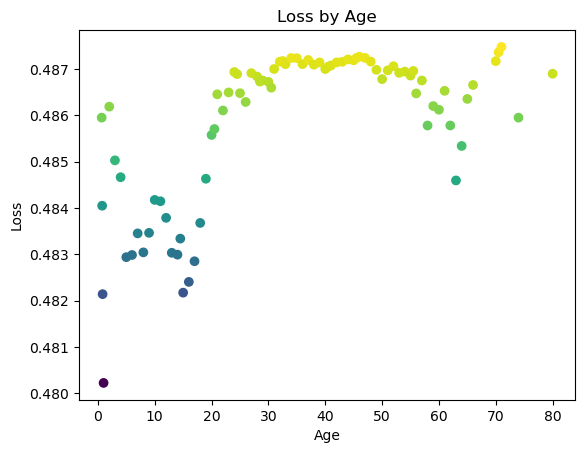

In [21]:
plt.scatter(x=unique, y=scores,c=scores)
plt.title("Loss by Age")
plt.xlabel("Age")
plt.ylabel("Loss")

Kind of a funny shape as there's also a decent split at age ~65 but still by far splitting at age ~1 has the lowest error.

Lets now write a function to do this for all our columns

In [22]:
def minimum_column(df, name):
    column, y = df[name], df[dependent]
    unique = column.dropna().unique()
    scores = np.array([score(column, y, o) for o in unique if not np.isnan(o)])
    idx = scores.argmin()
    return unique[idx], scores[idx]

minimum_column(train_df, "Age")

(1.0, 0.48022328558413757)

And for all the columns

In [23]:
columns = categorical_columns + continuous_columns
{o:minimum_column(train_df, o) for o in columns}

{'Sex': (0, 0.40174577324058475),
 'Embarked': (0, 0.4811504694588385),
 'Age': (1.0, 0.48022328558413757),
 'SibSp': (0, 0.483227569996794),
 'Parch': (0, 0.4801137707414689),
 'LogFare': (2.5257286443082556, 0.46121782955908514),
 'Pclass': (2, 0.4624955937741366)}

Sex is still the best split with a .4017 error being the lowest.

### OneR Classifier

What we've built so far is a variant of the OneR classifier, a single binary split. [From the paper mentioned in the book](https://link.springer.com/article/10.1023/A:1022631118932), this was one of the most effective classifiers in real-world datasets in the 90s when it was written. The elegance and simplicity being effective as well as stacking these together makes random forests and gradient boosted models is amazing. Building this as a baseline and beating any kind of heavier working model seems like the biggest flex, absolutely going to keep it in my toolbelt for newer problems I come across.

### Creating a Decision Tree

Lets not iterate on a single binary split and create another binary split for each group, using the above example, we'd now find the best threshold split for the male group and female group respectively, giving us 3 binary splits and 4 final groups, each having been through two splits.

Lets create our two groups and run our minimum_column split over both to find the best splits for each group

In [24]:
# columns.remove("Sex")
ismale = train_df.Sex==1
males, females = train_df[ismale], train_df[~ismale]

{o:minimum_column(males,o) for o in columns}, {o:minimum_column(females,o) for o in columns}

({'Sex': (1, 0.3866600965702336),
  'Embarked': (0, 0.3851830786796578),
  'Age': (12.0, 0.3699562535314519),
  'SibSp': (0, 0.3851282018354994),
  'Parch': (0, 0.38219087835649423),
  'LogFare': (3.275887339030031, 0.3693625776944378),
  'Pclass': (1, 0.3752653977518116)},
 {'Sex': (0, 0.4295419349353169),
  'Embarked': (0, 0.42333385655074074),
  'Age': (45.0, 0.4207103503408563),
  'SibSp': (2, 0.4136208139050961),
  'Parch': (3, 0.4195622485481227),
  'LogFare': (3.705920919968788, 0.3831130028684404),
  'Pclass': (2, 0.3540435880443141)})

Our best male split is LogFare at 3.27 with an error of .3693, just beating out splitting by Age at a .3699 error rate.

For our female group, the best split is Pclass at 2 and an error of .35404

If we combine these binary splits, we've made a very small decision tree, we could hack together some more python and do this ourselves, or use sklearn to do the heavy lifting for us:

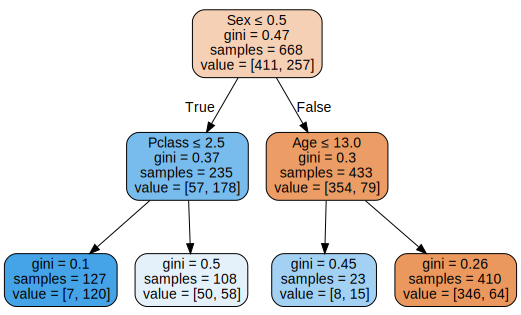

In [25]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz

tree = DecisionTreeClassifier(max_leaf_nodes=4).fit(train_xs, train_y)

def draw_tree(tree, df, size=10, ratio=0.6, precision=2, **kwargs):
    s = export_graphviz(tree,
                        out_file=None,
                        feature_names=df.columns,
                        filled=True,
                        rounded=True,
                        special_characters=True,
                        rotate=False,
                        precision=precision,
                       **kwargs)
    return graphviz.Source(re.sub("Tree {",f"Tree {{ size={size}; ratio={ratio}", s))

draw_tree(tree, train_xs, size=10)

Not quite identical to our split, the tree has gone with "Age" instead of logfare for the male class but no surprises there, our Age loss was almost identical to our LogFare best loss. It's agreed with our manual split of Pclass for females however.

Graphviz looks a little finicky but its great to be able to visualise a tree like this, absolutely worth doing to understand how the decisions are being made and you can follow any particular row of data to its final prediction.

The other things to note are both the colour of the nodes, orange being higher chance of death, blue being higher for survival, and the 'gini' value on each node. I'm fairly confident that this is using the ['gini impurity' metric and not the 'gini coefficient' which are often mistaken for each other](https://datascience.stackexchange.com/questions/1095/gini-coefficient-vs-gini-impurity-decision-trees). Whenever I've read commentary on 'gini', its usually referring to the coefficient which seems to be a measurement of 'inequality' and is commonly used in census and country/economic statistics. I don't have an intuitive way to slice these apart as they both discuss/are used when trying to understand the similarity or different between members of a particular group. I may come back to this and write a deeper explanation of the nuance here.

Lets write an implementation of gini to dig a bit deeper

In [26]:
def gini(condition):
    population = df.loc[condition, dependent]
    return 1 - population.mean()**2 - (1-population).mean()**2

Lets checkout each line and build some intuition for gini

In [27]:
population = df.loc[df.Sex=="female", dependent]
population

1      1
2      1
3      1
8      1
9      1
      ..
880    1
882    0
885    0
887    1
888    0
Name: Survived, Length: 314, dtype: int64

So we've first grabbed all rows that match our 'condition' which is our group we want to build a gini of. We then build a few terms which we square and then subtract from each other

In [28]:
population.mean(), (1-population).mean()

(0.7420382165605095, 0.25796178343949044)

In [29]:
population.mean()**2, (1-population).mean()**2

(0.5506207148363016, 0.06654428171528257)

We can see the $1-population$ term shrinks when squared since its below 0 which pushes the below calculation towards 0, meaning a more pure group. Ie the less of $1-population$ which are incorrect labels, the more pure the group, makes sense.

In [30]:
1 - population.mean()**2 - (1-population).mean()**2

0.3828350034484158

The quote from [wiki for gini impurity](https://en.wikipedia.org/wiki/Decision_tree_learning#Gini_impurity) "*is a measure of how often a randomly chosen element from the set would be incorrectly labeled if it was randomly labeled according to the distribution of labels in the subset.*" Which makes sense but doesn't feel too intuitive to me. Nonetheless, 0 is perfectly pure since there is a 0 probability of picking an incorrect label and 1 is perfectly impure since there is a guarantee you'll pick an incorrect label. Lets move on

In [31]:
gini(df.Sex=="female"), gini(df.Sex=="male")

(0.3828350034484158, 0.3064437162277842)

We can checkout our tree performance compared to our OneR model now as well

In [32]:
mean_absolute_error(validation_y, tree.predict(validation_xs))

0.25112107623318386

Remember that just splitting by sex gave us an mae of 0.242152466367713, we've actually got worse by building this small tree. Lets try building a bigger tree with more splits

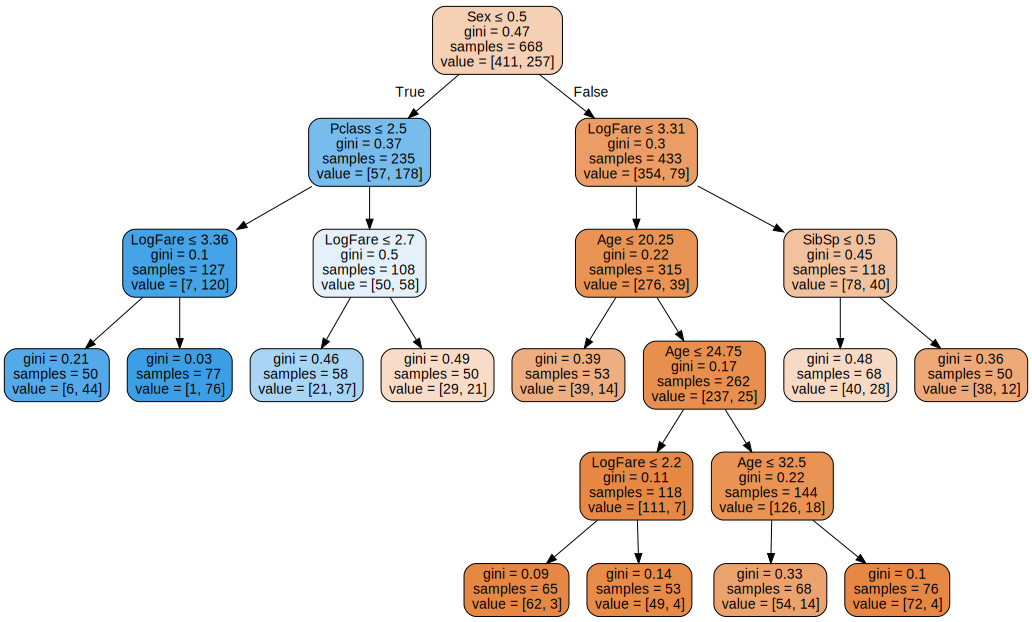

In [33]:
tree = DecisionTreeClassifier(min_samples_leaf=50)
tree.fit(train_xs, train_y)
draw_tree(tree, train_xs, size=25)

In [34]:
mean_absolute_error(validation_y, tree.predict(validation_xs))

0.20179372197309417

This is a better performing model, not by a long way but still distinguishable from the OneR model. Still blows my mind that OneR is that effective for this dataset. Lets move to random forests which are an ensemble of decision trees.

### Random Forests & Bagging

Since there aren't many samples in each leaf node of the above tree, we can't enlarge the tree with more splits very effectively, as fastbook states, "Leo Breiman" had a really fascinating insight, "what if we create lots of bigger trees, and then take the average prediction of a bunch of models." This is known as [bagging](https://link.springer.com/article/10.1007/BF00058655), this paper is from 1980! I'm always blown away at how impactful work done in the 80s and 90s was for building the models we use today but also that it took such a long time to trickle into day to day software engineering and data science.

To paraphrase fastbook again, each model will be slightly biased above or below the true value since they will be trained on a random subset of the data and thus will be uncorrelated with each other, if we average out these errors then we're likely to approximate the ground truth underlying these trees. The book notes that "the average of lots of uncorrelated random errors is zero" which is a really fascinating thought.

Lets manually do this random subsetting and training

In [35]:
def get_tree(prop=0.8):
    n = len(train_y)
    idxs = random.choice(n, int(n*prop))
    return DecisionTreeClassifier(min_samples_leaf=5).fit(train_xs.iloc[idxs], train_y.iloc[idxs])

Similar to gini, lets break this down line by line

In [36]:
n = len(train_y)
n

668

This is just how many samples we would like

In [37]:
idxs = random.choice(n, int(n*0.8))
idxs[:10], int(n*0.8)

(array([320, 342, 256, 571, 392, 118, 350, 275, 316, 337]), 534)

The second term here is 'size' in the random.choice method which means generate 534 samples from a random sample produced like `np.arange(n)` which is what we've given, checkout the docs below

In [38]:
random.choice?

Docstring:
choice(a, size=None, replace=True, p=None)

Generates a random sample from a given 1-D array

.. versionadded:: 1.7.0

.. note::
    New code should use the ``choice`` method of a ``default_rng()``
    instance instead; please see the :ref:`random-quick-start`.

Parameters
----------
a : 1-D array-like or int
    If an ndarray, a random sample is generated from its elements.
    If an int, the random sample is generated as if it were ``np.arange(a)``
size : int or tuple of ints, optional
    Output shape.  If the given shape is, e.g., ``(m, n, k)``, then
    ``m * n * k`` samples are drawn.  Default is None, in which case a
    single value is returned.
replace : boolean, optional
    Whether the sample is with or without replacement. Default is True,
    meaning that a value of ``a`` can be selected multiple times.
p : 1-D array-like, optional
    The probabilities associated with each entry in a.
    If not given, the sample assumes a uniform distribution over all
    entr

Ok so we then get n samples from a random sample of the np.arange(n) generate length as indexes, we then fit the tree model and save that as a tree, awesome, that sounds just like our description of training a tree on a random subset. Lets now build a bunch of trees

In [39]:
trees = [get_tree() for t in range(100)]

And we want to predict the average of all of these trees

In [40]:
all_probabilities = [t.predict(validation_xs) for t in trees]
all_probabilities[:3], len(all_probabilities)

([array([1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1,
         0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1,
         0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1,
         0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0,
         1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,
         0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
         1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1,
         0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1,
         1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0,
         1, 0, 1], dtype=int64),
  array([1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1,
         0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
         0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

We've got our vector of predictions for each tree, we want to stack them all together and get a mean now for the average of all the trees

In [41]:
np.stack(all_probabilities), len(np.stack(all_probabilities))

(array([[1, 1, 1, ..., 1, 0, 1],
        [1, 1, 1, ..., 1, 0, 0],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [0, 1, 1, ..., 1, 0, 0],
        [1, 1, 1, ..., 1, 0, 0],
        [0, 1, 1, ..., 0, 1, 1]], dtype=int64),
 100)

Ok so we've got 100 stacked matrices of predictions, lets now grab the mean for each index to get the average prediction

In [42]:
np.stack(all_probabilities).mean(0), len(np.stack(all_probabilities).mean(0)), len(validation_xs)

(array([0.85, 0.94, 0.87, 0.98, 0.12, 0.37, 0.06, 0.95, 1.  , 0.75, 0.04,
        1.  , 0.07, 0.99, 0.  , 0.21, 0.84, 0.  , 0.09, 0.73, 0.9 , 1.  ,
        0.  , 0.15, 0.68, 0.01, 0.36, 0.39, 0.51, 0.1 , 0.  , 0.04, 0.  ,
        0.09, 0.44, 0.21, 0.  , 0.  , 1.  , 0.42, 0.68, 0.21, 0.03, 1.  ,
        0.23, 1.  , 1.  , 0.01, 0.06, 0.  , 0.1 , 0.63, 0.06, 0.06, 0.15,
        0.06, 0.53, 0.66, 0.17, 0.15, 0.11, 0.64, 0.  , 0.06, 0.  , 0.8 ,
        0.05, 0.01, 0.98, 0.05, 0.01, 0.25, 0.1 , 1.  , 0.14, 0.04, 0.15,
        1.  , 0.  , 0.38, 0.09, 0.24, 0.11, 0.22, 0.23, 0.97, 0.28, 0.05,
        0.31, 1.  , 0.07, 0.  , 0.64, 0.8 , 0.9 , 0.05, 0.  , 0.39, 0.2 ,
        0.02, 0.1 , 0.29, 0.3 , 0.  , 0.  , 0.09, 0.37, 0.4 , 1.  , 1.  ,
        0.  , 0.08, 0.15, 0.02, 0.04, 0.1 , 0.62, 1.  , 0.26, 0.15, 0.73,
        0.  , 0.4 , 1.  , 0.16, 0.01, 0.  , 0.07, 0.01, 0.11, 0.  , 0.09,
        0.99, 0.03, 0.84, 0.94, 1.  , 0.01, 0.01, 0.92, 1.  , 0.06, 0.02,
        0.98, 1.  , 0.89, 0.98, 0.07, 

There's our predictions for each entry of the validation set

In [43]:
average_probabilities = np.stack(all_probabilities).mean(0)

In [44]:
mean_absolute_error(validation_y, average_probabilities)

0.2224663677130045

Not fantastically better but cool to see how these trees get put together, we can of course use sklearn's library to do something extemely similar except sklearn will also subset the columns and not just the observations like we've done here.

In [45]:
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier(100, min_samples_leaf=5)
random_forest.fit(train_xs, train_y)
mean_absolute_error(validation_y, random_forest.predict(validation_xs))

0.18834080717488788

Ok thats a decently better performance, how interesting that learning from less columns actually improved the accuracy by such a distance, thats amazing!

The other interesting output of random forests is the 'feature importance' concept which is directly accessible on the forest itself, we can visualise it fairly easily too.

<AxesSubplot: ylabel='cols'>

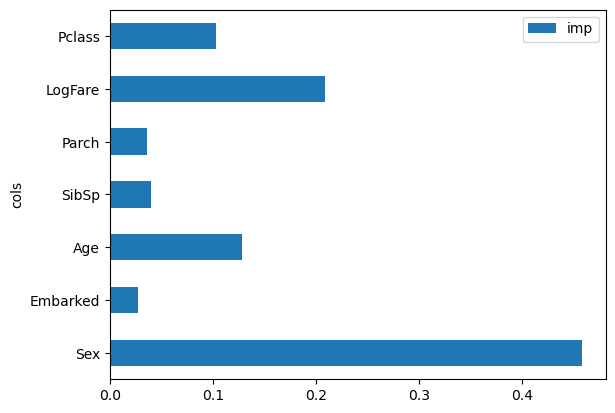

In [46]:
pd.DataFrame(dict(cols=train_xs.columns, imp=random_forest.feature_importances_)).plot("cols", "imp", "barh")

As we first investigated, Sex is the dominant feature as to whether someone survived and LogFare being the next most valuable, next to Age and PClass which makes sense with our preliminary investigation.

## Book Content

We've finished the content relative to the lecture, we'll move onto chapter 9 of the book which focuses on tabular data like we've worked on so far but instead we use the "Blue Book for Bulldozers" Kaggle dataset.

### Quick Note on Embeddings

The book also starts off explaining Neural Network embeddings and its one of my favourite if not my favourite explanation of embeddings which I found very difficult on first read. I've actually [written a blog on understanding embeddings from my four favourite sources here](https://nglillywhite.quarto.pub/nicks-blog/posts/2022-2-08-embeddings%20described%204%20ways.html) if you'd like to hear my thoughts and smarter people than me discuss the topic. I won't re-hash the content here.

### Blue Book for Bulldozers

The dataset we're working with is the Kaggle 'Blue Book for Bulldozers' dataset which describes various bulldozers and their expected market price, the competition in particular is to predict the sale price of the equipment, given some metadata about the bulldozers such as year it was built, usage, type, configuration, etc.

### Becoming a Kaggle Gangster

Jeremy makes an awesome point about kaggle competitions that they're great because the feedback is brutally honest and real, if your score sucks, your model sucks, there's no hiding, no faking, no wrong perception if you're a great data scientist or not, its all there in the score. Of course there's more complexity to the profession but at the end of the day, if your model doesn't effectively solve the problem you're building it for, it isn't good!

I'm definitely going to pivot in these later lessons to doing a kaggle competition blog/writeup in parallel with the course, I'm certainly feeling more confident with the library and my understanding as I continue to write and expect to see some standalone competition posts as I progress over the next few lessons. I've been hiding under the 'learning' guise and its time I start getting slapped with some loss metrics. I've waited in particular to this lesson to pivot to competitions because of the "Road to the Top" content & "Iterate like a Grandmaster" notebooks which show how Jeremy iterates to a gold model for some competitions. I have at this time not built up the intuition for problem solving data science problems like these notebooks demonstrate and instead have been learning the library and core concepts. This will be a pivotal week and I'm excited as well as intimidated but in a good way, this all feels very 'growthy'.

Moving on from my personal emotional and mental state, lets get back to ripping down this data and building a deeper understanding of Random Forests

### BullDozer Data and Cleaning

In [47]:
from fastai.imports import *
from fastai.vision.all import *

competition = "bluebook-for-bulldozers"
path = Path("../data/bluebook-for-bulldozers")
path

Path('../data/bluebook-for-bulldozers')

In [48]:
from kaggle import api

path.mkdir(exist_ok=True)
api.competition_download_cli(competition, path=path)
shutil.unpack_archive(str(path/f"{competition}.zip"),str(path))

path.ls(file_type="text")

bluebook-for-bulldozers.zip: Skipping, found more recently modified local copy (use --force to force download)


(#0) []

In [49]:
df = pd.read_csv(path/"TrainAndValid.csv", low_memory=False)
df.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000.0,999089,3157,121,3.0,2004,68.0,Low,11/16/2006 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
1,1139248,57000.0,117657,77,121,3.0,1996,4640.0,Low,3/26/2004 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1139249,10000.0,434808,7009,121,3.0,2001,2838.0,High,2/26/2004 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1139251,38500.0,1026470,332,121,3.0,2001,3486.0,High,5/19/2011 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1139253,11000.0,1057373,17311,121,3.0,2007,722.0,Medium,7/23/2009 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Looks like lots of NaNs and a mix of categorical and continuous variables, lets look at the size and columns

In [50]:
len(df), df.columns

(412698,
 Index(['SalesID', 'SalePrice', 'MachineID', 'ModelID', 'datasource',
        'auctioneerID', 'YearMade', 'MachineHoursCurrentMeter', 'UsageBand',
        'saledate', 'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc',
        'fiModelSeries', 'fiModelDescriptor', 'ProductSize',
        'fiProductClassDesc', 'state', 'ProductGroup', 'ProductGroupDesc',
        'Drive_System', 'Enclosure', 'Forks', 'Pad_Type', 'Ride_Control',
        'Stick', 'Transmission', 'Turbocharged', 'Blade_Extension',
        'Blade_Width', 'Enclosure_Type', 'Engine_Horsepower', 'Hydraulics',
        'Pushblock', 'Ripper', 'Scarifier', 'Tip_Control', 'Tire_Size',
        'Coupler', 'Coupler_System', 'Grouser_Tracks', 'Hydraulics_Flow',
        'Track_Type', 'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb',
        'Pattern_Changer', 'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type',
        'Travel_Controls', 'Differential_Type', 'Steering_Controls'],
       dtype='object'))

Almost half a million rows and 53 columns in total, much bigger than anything we've played around with so far. Lets investigate a few columns in particular and do some cleaning up, as following the book, fastai starts with 'ProductSize'

In [51]:
df.ProductSize.unique()

array([nan, 'Medium', 'Small', 'Large / Medium', 'Mini', 'Large',
       'Compact'], dtype=object)

We've discussed categorical column types in pandas earlier but in this case its also ordered, which we can set similarly to the category we did before.

In [52]:
sizes = ["Large", "Large / Medium", "Medium", "Small", "Mini", "Compact"]

df.ProductSize = df.ProductSize.astype("category")
df.ProductSize.cat.set_categories(sizes, ordered=True, inplace=True)

C:\Users\Nick\Anaconda3\envs\fastai\lib\site-packages\pandas\core\arrays\categorical.py:2747: FutureWarning: The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)


###  Metric Selection

The book discusses metric selection as a design process for your problem in the real world, something you iterate and think deeply about as to how best get a measurement of success for your problem. I'm going to [re-link the awesome Rachel Thomas article discussing this problem](https://www.fast.ai/posts/2019-09-24-metrics.html) which talks through the problems of metrics being proxies and why this is such an important problem. We're very lucky in Kaggle competitions as this loss function is already decided for us but I didn't want to dance over this important and interesting point made in the book at this point.

In this competition, its Root Mean Squared Log Error (RMSLE) which is very common

In [53]:
dependent_variable = "SalePrice"
df[dependent_variable] = np.log(df[dependent_variable])

### Date Handling

I've experienced this firsthand at work that dates are scary and mercurial things, don't try and do any of the math yourself, rely on libraries and do any research and you'll discover just how many damn calendars and timezones and attempts there are to organise and represent time accurately; Jan 1st 1970 will also begin to haunt you. In our case, fastai has an awesome helper function call add_datepart() which will enrich our date data of our dataset. I wanted to make this point just to offer up the wormhole to go down, but also with a warning that you wont find a satisfying solution.

In [54]:
from fastai.tabular.all import *

df = add_datepart(df, "saledate")

In [55]:
df_test = pd.read_csv(path/"Test.csv", low_memory=False)
df_test = add_datepart(df_test, "saledate")

Checkout these cool new date columns that have been made

In [56]:
[o for o in df.columns if o.startswith("sale")]

['saleYear',
 'saleMonth',
 'saleWeek',
 'saleDay',
 'saleDayofweek',
 'saleDayofyear',
 'saleIs_month_end',
 'saleIs_month_start',
 'saleIs_quarter_end',
 'saleIs_quarter_start',
 'saleIs_year_end',
 'saleIs_year_start',
 'saleElapsed']

### TabularPandas and TabularProc

TabularPandas is a fastai wrapper to a pandas dataframe which provides a few handy, nifty helpers and TabularProc is a form of fastai Transform that works the same as other Transform classes but:
 - It returns the same object that is passed to it
 - "It runs the transformation once when the data is passed in instead of lazily as the data is accessed"
 
I haven't covered the "Transform" class in fastai yet within the coursework explicitly so far, I'm sure we've used them as part of our Learner objects and item/batch_tfms but I haven't dove deep into them yet. I think thats ok and the important thing to know is that it transforms our data for us in a slightly different but similar way to other transformations as mentioned above from the book.

"Categorify" replaces categorical columns with a numerical column representation and "FillMissing" will deal with missing values by filling with the median which we've both done manually before.

In [57]:
procs = [Categorify, FillMissing]

### Validation Set

As we've talked about a few times in this course so far (and as explicitly mentioned in the book), building the right validation set is really important to success. [Rachel Thomas again writes better than I ever will](https://www.fast.ai/posts/2017-11-13-validation-sets.html) on the topic and explains how key this is to the problem.

The reason this is mentioned here is because TabularPandas will automatically build a validation set for you but you want to make sure it matches the kind of validation set that will be hidden from us in Kaggle. In particular Time Series is important to specify since we can't just randomly slice out observations, we need to slice out a chunk of linear time such as the final year, to mimic predicting the next year etc.

In [58]:
condition = (df.saleYear < 2011) | (df.saleMonth < 10)
train_idx = np.where(condition)[0]
valid_idx = np.where(~condition)[0]

splits = (list(train_idx),list(valid_idx))

In [59]:
continuous_columns, categorical_columns = cont_cat_split(df, 1, dep_var=dependent_variable)

In [60]:
to = TabularPandas(df=df,
                   procs=procs,
                   cat_names=categorical_columns,
                   cont_names=continuous_columns,
                  y_names=dependent_variable,
                  splits=splits)

In [61]:
len(to.train), len(to.valid)

(404710, 7988)

In [62]:
to.show(3)

,UsageBand,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,auctioneerID_na,MachineHoursCurrentMeter_na,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,saleYear,saleMonth,saleWeek,saleDay,saleDayofweek,saleDayofyear,saleElapsed,SalePrice
0,Low,521D,521,D,#na#,#na#,#na#,Wheel Loader - 110.0 to 120.0 Horsepower,Alabama,WL,Wheel Loader,#na#,EROPS w AC,None or Unspecified,#na#,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,2 Valve,#na#,#na#,#na#,#na#,None or Unspecified,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Standard,Conventional,False,False,False,False,False,False,False,False,1139246,999089,3157,121,3.0,2004,68.0,2006,11,46,16,3,320,1.163635e+09,11.097410
1,Low,950FII,950,F,II,#na#,Medium,Wheel Loader - 150.0 to 175.0 Horsepower,North Carolina,WL,Wheel Loader,#na#,EROPS w AC,None or Unspecified,#na#,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,2 Valve,#na#,#na#,#na#,#na#,23.5,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Standard,Conventional,False,False,False,False,False,False,False,False,1139248,117657,77,121,3.0,1996,4640.0,2004,3,13,26,4,86,1.080259e+09,10.950807
2,High,226,226,#na#,#na#,#na#,#na#,Skid Steer Loader - 1351.0 to 1601.0 Lb Operating Capacity,New York,SSL,Skid Steer Loaders,#na#,OROPS,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Auxiliary,#na#,#na#,#na#,#na#,#na#,None or Unspecified,None or Unspecified,None or Unspecified,Standard,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,False,False,False,False,False,False,False,False,1139249,434808,7009,121,3.0,2001,2838.0,2004,2,9,26,3,57,1.077754e+09,9.210340


Yes we can still see some string representations, but to prove they're still numbers under the hood, lets checkout the underlying codes

In [63]:
to1 = TabularPandas(df,
                    procs=procs,
                    cat_names=["state","ProductGroup","Drive_System","Enclosure"],
                    cont_names=[],
                    y_names=dependent_variable,
                    splits=splits)

to1.show(2)

,state,ProductGroup,Drive_System,Enclosure,SalePrice
0,Alabama,WL,#na#,EROPS w AC,11.097410
1,North Carolina,WL,#na#,EROPS w AC,10.950807


In [64]:
to.items.head(3)

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,saleDayofyear,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,saleElapsed,auctioneerID_na,MachineHoursCurrentMeter_na
0,1139246,11.097410,999089,3157,121,3.0,2004,68.0,2,963,...,320,1,1,1,1,1,1,1.163635e+09,1,1
1,1139248,10.950807,117657,77,121,3.0,1996,4640.0,2,1745,...,86,1,1,1,1,1,1,1.080259e+09,1,1
2,1139249,9.210340,434808,7009,121,3.0,2001,2838.0,1,336,...,57,1,1,1,1,1,1,1.077754e+09,1,1


In [65]:
to1.items[["state","ProductGroup","Drive_System"]].head(3)

,state,ProductGroup,Drive_System
0,1,6,0
1,33,6,0
2,32,3,0


In [66]:
to.classes["ProductSize"]

['#na#', 'Large', 'Large / Medium', 'Medium', 'Small', 'Mini', 'Compact']

### Making Another Tree

Lets go through the tree process again which we now understand deeply with our new dataset

In [67]:
xs, y = to.train.xs, to.train.y
valid_xs, valid_y = to.valid.xs, to.valid.y

In [68]:
from sklearn.tree import DecisionTreeRegressor
tree = DecisionTreeRegressor(max_leaf_nodes=4)
tree.fit(xs,y)

DecisionTreeRegressor(max_leaf_nodes=4)

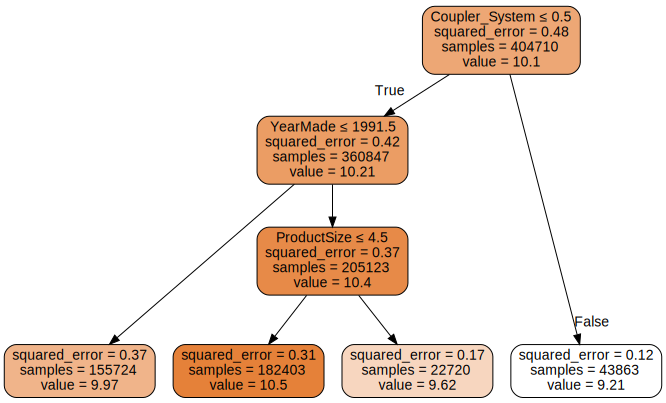

In [69]:
draw_tree(tree,
          df=xs,
         size=10,
         leaves_parallel=True,
         precision=2)

We've worked through this visualisation before but its cool to see a different dataset and how the tree gets constructed. YearMade is the first most important split, it then goes to ProductSize, note we've limited the tree to very few nodes despite how many observations we have for us to best understand these early splits. Lets also look at the dtreeviz library to understand our tree

C:\Users\Nick\Anaconda3\envs\fastai\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names


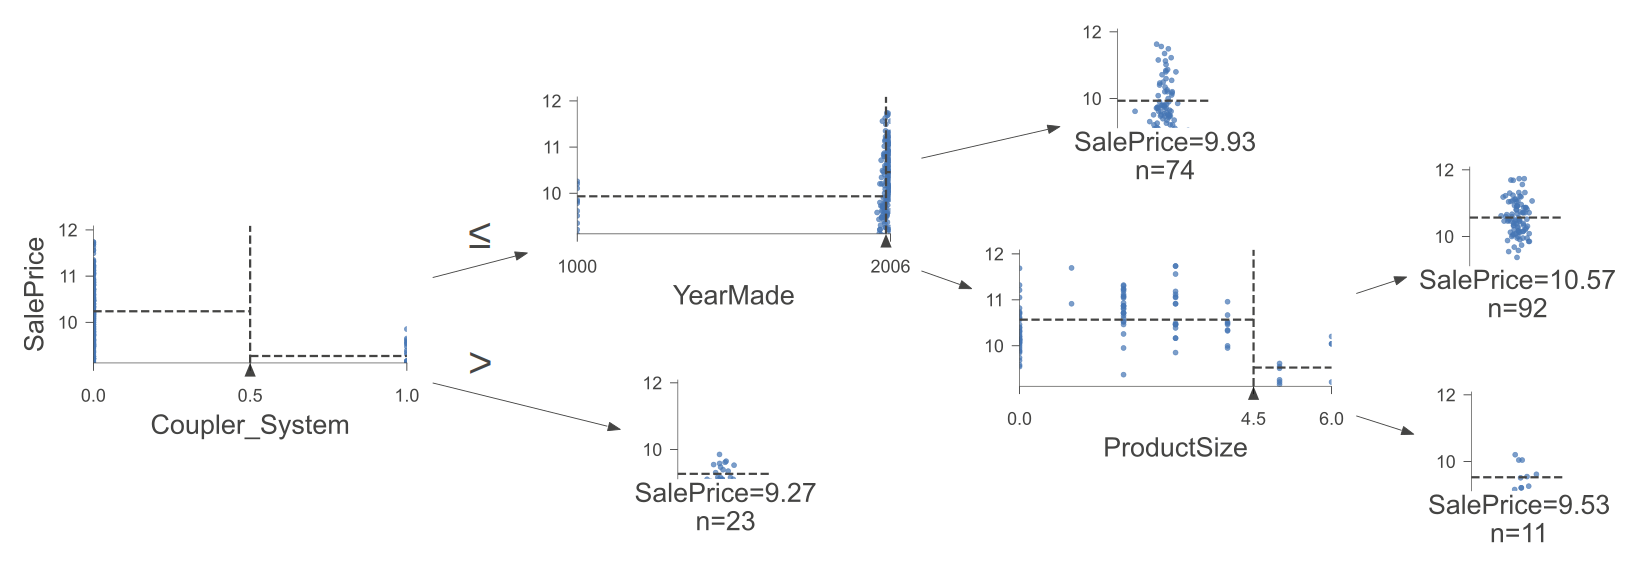

In [70]:
import dtreeviz

sample_indx = np.random.permutation(len(y))[:200]

viz = dtreeviz.model(model=tree,
                     X_train=xs.iloc[sample_indx],
                     y_train=y.iloc[sample_indx],
                     feature_names=xs.columns,
                     target_name=dependent_variable)

viz.view(scale=3,orientation="LR")

This is a really nice visualisation of the data samples for each node and leaf of our tree, we can now expand our tree to not limit how many leaf nodes it builds and see how it changes

In [71]:
tree = DecisionTreeRegressor()
tree.fit(xs,y)

DecisionTreeRegressor()

Lets make a Root Mean Squared Error (rmse) function and a helper to score our tree

In [72]:
def rmse(predictions, y): return round(math.sqrt(((predictions-y)**2).mean()),6)
def model_rmse(model, xs,y): return rmse(model.predict(xs),y)

model_rmse(tree, xs, y)

0.0

Perfect score, are we done?

**insert inbetweeners meme of "data science? Completed it mate."**

Lets check for overfitting and how many leaves we got

In [73]:
model_rmse(tree, valid_xs, valid_y)

0.334539

Pranked, totally overfit, there's a big difference between our training loss and validation loss

In [74]:
tree.get_n_leaves(), len(xs)

(324581, 404710)

\~325,000 leaf nodes and only \~400,000 observations, almost a leaf node for every observation, this is not good. Lets limit each leaf to have a minimum sample size to reduce the chances of us building a tree that doesn't generalise too well.

In [75]:
tree = DecisionTreeRegressor(min_samples_leaf=25)
tree.fit(to.train.xs, to.train.y)
model_rmse(tree, xs, y), model_rmse(tree, valid_xs, valid_y)

(0.211677, 0.268165)

Hey look our losses are much closer together, this is way better, our training loss is somewhat indicative of our performance on an unseen dataset

In [76]:
tree.get_n_leaves()

12397

Only \~12,000 leaves, much more reasonable considering the \~400,000 observations we've got

### Returning to Bagging

In this chapter, the book focuses on discussing Random Forests specifically but I really like that the book discusses "Bagging" as its own topic, since you could ensemble 'any' models together and as long as their errors are uncorrelated and the bias is random, the average should move towards the ground truth. I'm focusing on committing this to memory as an important process in 'any' modelling context and not just stacking decision trees together, nonetheless lets create a random forest and checkout our rmse errors in comparison to our decision tree.

In [77]:
from sklearn.ensemble import RandomForestRegressor
def random_forest(xs,y,
                 n_estimators=40,
                 max_samples=200_000,
                 max_features=0.5,
                 min_samples_leaf=5,**kwargs):
    return RandomForestRegressor(n_jobs=-1,
                                n_estimators=n_estimators,
                                max_samples=max_samples,
                                max_features=max_features,
                                min_samples_leaf=min_samples_leaf,
                                oob_score=True).fit(xs,y)

In [78]:
tree = random_forest(xs, y)
model_rmse(tree, xs, y), model_rmse(tree, valid_xs, valid_y)

(0.170761, 0.235279)

Much better, over a 10% reduction in validation error and \~20% reduction on the train set, very little extra effort and no new data changes were made, simply just lots of trees and the bagging subset process of both observations and features, really interesting. Lets checkout the impact of progressively adding trees in our model so we can see how our error reduces as more trees learn the dataset sample they're given.

In [79]:
#| warning: false
preds = np.stack([t.predict(valid_xs) for t in tree.estimators_])

rmse(preds.mean(0), valid_y)

C:\Users\Nick\Anaconda3\envs\fastai\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
C:\Users\Nick\Anaconda3\envs\fastai\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
C:\Users\Nick\Anaconda3\envs\fastai\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
C:\Users\Nick\Anaconda3\envs\fastai\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
C:\Users\Nick\Anaconda3\envs\fastai\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
C:\Users\Nick\Anaconda3\envs\fastai\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without featur

0.235279

We can also checkout that the mean of all estimators is the same as our random forest output, becaues thats all its doing, which is averaging the prediction of all the trees.

Text(0, 0.5, 'Root Mean Squared Error (RMSE)')

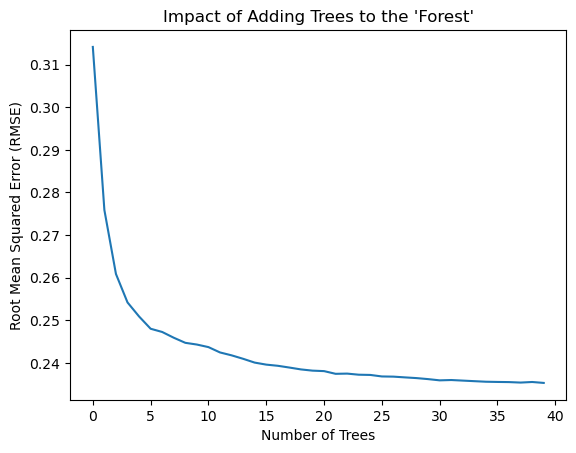

In [80]:
plt.plot([rmse(preds[:i+1].mean(0), valid_y) for i in range(40)])
plt.title("Impact of Adding Trees to the 'Forest'")
plt.xlabel("Number of Trees")
plt.ylabel("Root Mean Squared Error (RMSE)")

We can see that very quickly we get diminishing returns from adding trees but even just having \~10 trees is a massive improvement in performance, almost $1/3$rd of the entire error rate is reduced in the first \~10 trees.

An important question to answer is why our validation error is worse than our training set, this implies over-fitting, however it could be that our validation set covers a different time period and has different underlying principles that drive the sale price that we're predicting. At this point the book introduces "Out of Bag or OOB" error which can help us with this question.

### Out of Bag Error (OOB)

The out of bag error measures the prediction error of the training rows that *weren't* included in a particular tree's training process. The book explains this as "measuring prediction error on the training set by only including in the calculation of a row's error trees where that row was not included in training." The other intuition given from the book is "every tree was trained with a different randomly selected subset of rows, out-of-bag error is a little like imagining that every tree therefore also has its own validation set. That validation set is simply the rows that were not selected for that tree's training (or bag).

The book also notes this is particularly useful in cases where "there's only a small amount of training data as it allows us to see whether our model generalises well without removing items to create a validation set."

In [81]:
rmse(tree.oob_prediction_, y)

0.2106

Our OOB error is a decent bit (\~10%) lower than our validation set, this implies that something else is causes this disparity as well as our model not generalising according to the book. This will be adressed later it promises, and so we must wait, patient we shall be...

### Model Interpretation

Lets now investigate how we can probe our models to understand a few key questions:
 - How confident are we in our predictions
 - What influenced each prediction
 - Which columns gave the strongest predictive signal and what can we discard/ignore
 - How do predictions vary given change in a particular feature signal
 
These all sounds like valuable questions to work through, lets make a start

### Variance for Prediction Confidence

Averaging all our predictions gives us our forest's prediction, but what if some trees predict very different labels than other trees? I would say that implies low confidence since there's a higher disagreement within the group, we can measure this by looking at the standard deviation.

In [82]:
preds.shape

(40, 7988)

Preds hold our predictions for every tree, being 40 trees over 7,988 auctions in our validation set. Lets look at the standard deviation over all the trees for each auction

In [83]:
preds_std = preds.std(0)

In [84]:
preds_std[:5]

array([0.32082711, 0.12655768, 0.11857996, 0.28353584, 0.10041746])

Ok remember that a higher standard deviation implies more disagreement amongst the trees

Text(0, 0.5, 'Prediction Confidence / Standard Deviation')

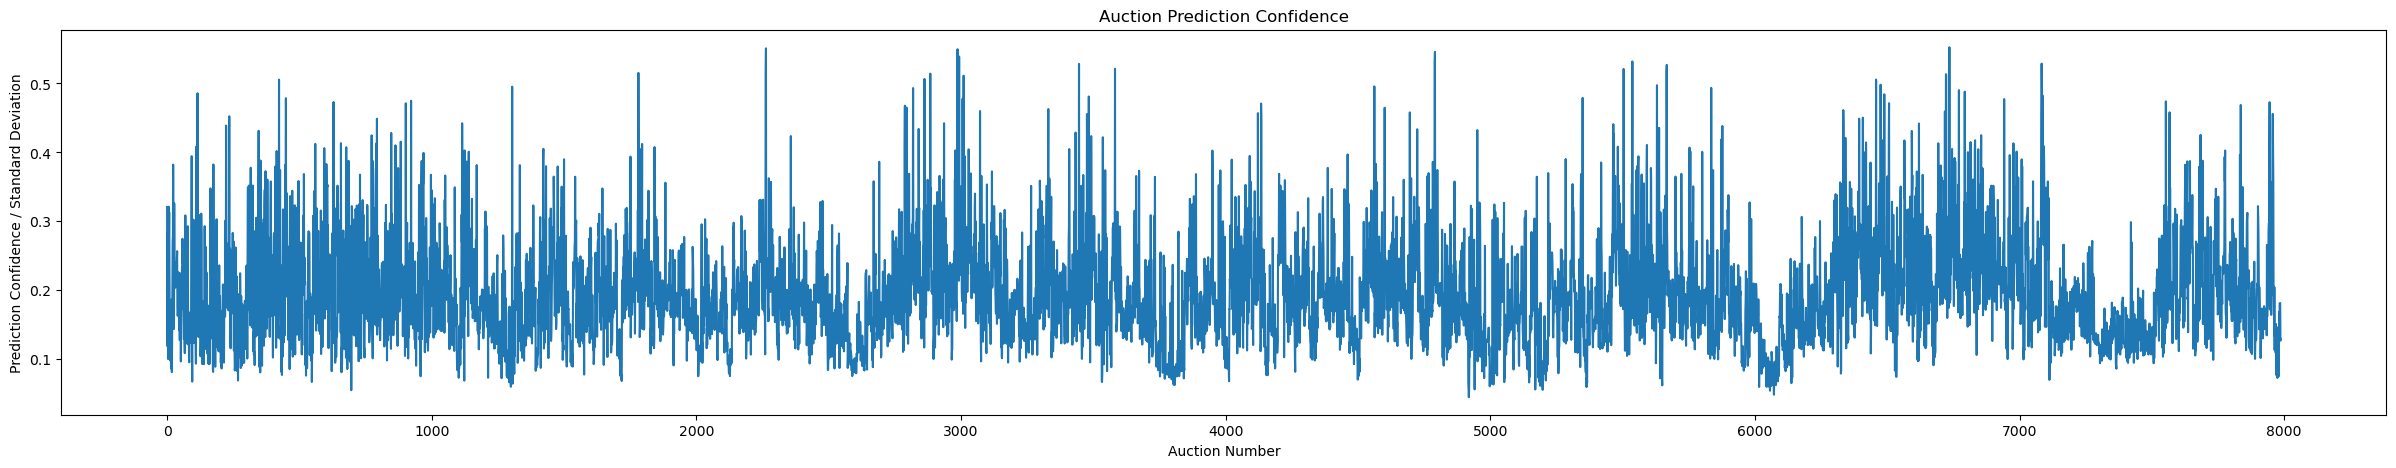

In [85]:
plt.figure(figsize=(30,5))
plt.plot(range(len(preds_std)),preds_std)
plt.title("Auction Prediction Confidence")
plt.xlabel("Auction Number")
plt.ylabel("Prediction Confidence / Standard Deviation")

We can see there's a fairly strong signal amongst the middle to low band but there's still an enormous difference in confidence between auctions, there are some very large spikes that stick out, might be interesting to see what kind of auctions our model finds particularly confusing

### Feature Importance

We've already investigated feature importance before, lets revisit for our random forest and new dataset

In [86]:
def random_forest_feature_importance(model,df):
    return pd.DataFrame({"cols":df.columns, "imp":model.feature_importances_}).sort_values("imp",ascending=False)

feature_importances = random_forest_feature_importance(tree, xs)
feature_importances[:10]

,cols,imp
57,YearMade,0.176700
6,ProductSize,0.127715
30,Coupler_System,0.115725
7,fiProductClassDesc,0.066285
54,ModelID,0.053376
65,saleElapsed,0.050343
3,fiSecondaryDesc,0.047855
32,Hydraulics_Flow,0.043004
31,Grouser_Tracks,0.035184
1,fiModelDesc,0.030892


Lets also visualise these values as it'll let us see the relative importance much more easily

<AxesSubplot: ylabel='cols'>

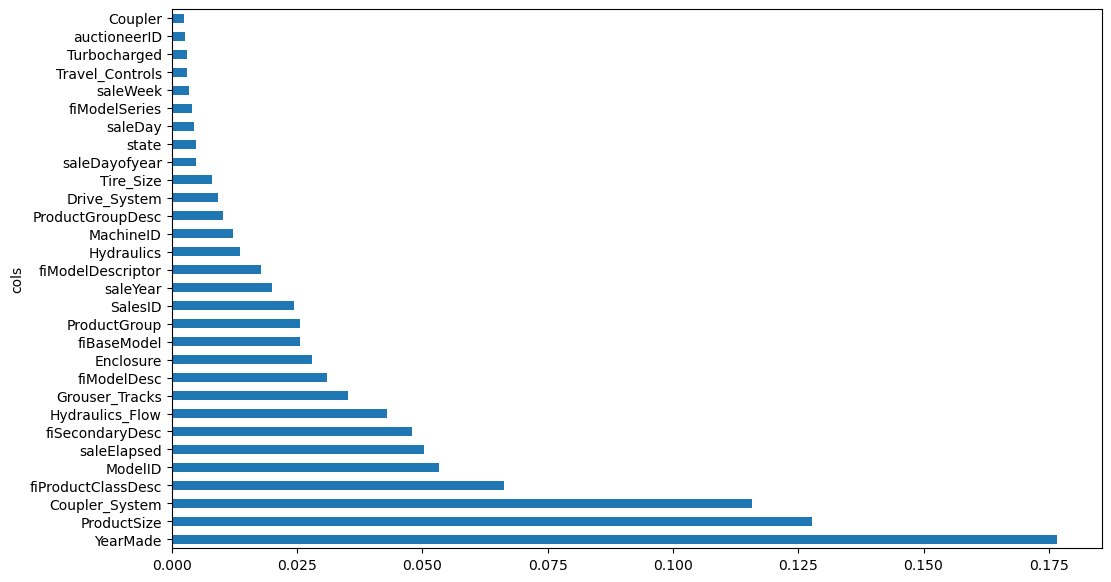

In [87]:
def plot_feature_importances(feature_importances):
    return feature_importances.plot("cols", "imp", "barh", figsize=(12,7), legend=False)

plot_feature_importances(feature_importances[:30])

These values are calculated in a really interesting fashion, the function to discover these values follows this pseudo-code:

1. Loop through each tree
2. Explore each branch
3. At each branch, see what feature was used for the split
4. Measure how much the model improved by weighting the number of rows in the split
5. Add this measure to the score for that particular feature
6. Sum these measures across all the branches of all the trees
7. Normalise the feature scores so they add up to 1

This gives us the intuition that Yearmade, ProductSize, and Coupler_System explain roughly a third of the predictions in our model, thats awesome! I wonder if you could make a OneR model / two or three split model that would perform 'decently' with just these top features.

### Discarding Low Value Features

Now that we know the relative value of features for prediction, we should be able to just keep the high 'signal' and effective features. Lets do that and drop low value features

In [88]:
feature_value_threshold = 0.005
valuable_features = feature_importances[feature_importances.imp>feature_value_threshold].cols
len(valuable_features)

21

Lets retrain on this subset of columns

In [89]:
xs_important = xs[valuable_features]
valid_xs_important = valid_xs[valuable_features]

tree = random_forest(xs_important, y)
model_rmse(tree, xs_important, y), model_rmse(tree, valid_xs_important, valid_y)

(0.181538, 0.231394)

We've replicated similar performance but with a third of the features

In [90]:
len(xs.columns), len(xs_important.columns)

(66, 21)

Simplifying whilst retaining performance is a better model, our feature importance plot should be more informative as well since we don't have a huge line of trailing features adding micro-boosts in performance

<AxesSubplot: ylabel='cols'>

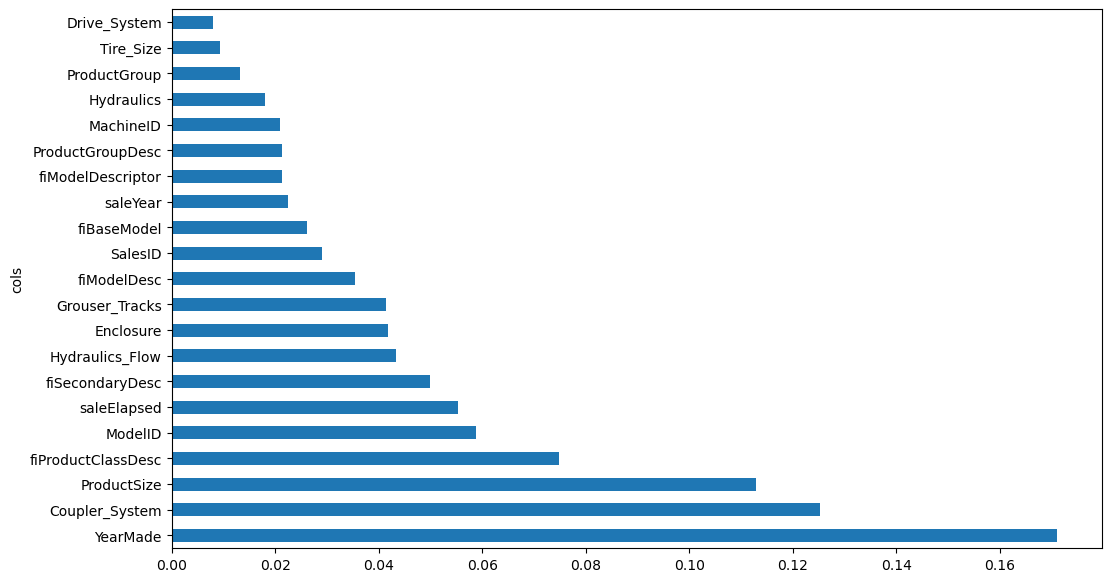

In [91]:
plot_feature_importances(random_forest_feature_importance(tree, xs_important))

### Redundant Features

Lets checkout fastai's cluster_columns function which allows us to look at what columns are correlated.

The book describes the intuition of this visualisation as features that are similar are ones that are merged 'earlier', meaning away from the root of the tree at the left. So columns that merge closely on the right side of the visualisation are very similar, in particular look at `MachineID` and `ModelID` as well as `ProductGroupDesc` and `ProductGroup`. These pairs merge almost instantly on the right and may actually be synonymous with each other and provide no individually useful signal.

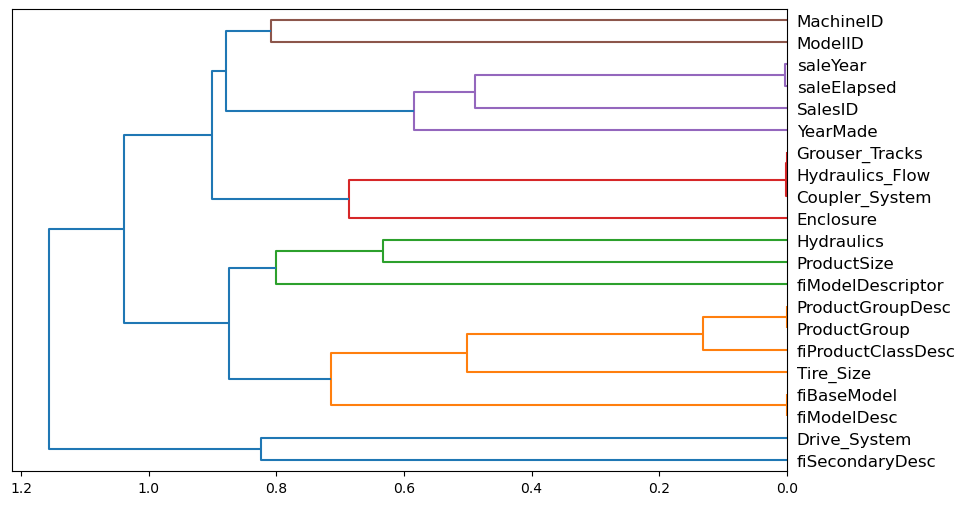

In [92]:
# Ripped from fastai/book_nbs/utils.py https://github.com/fastai/book_nbs/blob/a7548b8d7f81cc04d0a2d035d05497c6833048c1/utils.py
# Wasn't sure on the right import statement for this one, excuse me if there's a nice way to bring this in
def cluster_columns(df, figsize=(10,6), font_size=12):
    # Ripped from fastai/book_nbs/utils.py https://github.com/fastai/book_nbs/blob/a7548b8d7f81cc04d0a2d035d05497c6833048c1/utils.py
    from scipy.cluster import hierarchy as hc
    corr = np.round(scipy.stats.spearmanr(df).correlation, 4)
    corr_condensed = hc.distance.squareform(1-corr)
    z = hc.linkage(corr_condensed, method='average')
    fig = plt.figure(figsize=figsize)
    hc.dendrogram(z, labels=df.columns, orientation='left', leaf_font_size=font_size)
    plt.show()

cluster_columns(xs_important)

We can try removing some of these duplicated features and see if our model performance drops by a noticable margin. First lets build a function that gives us back an oob error and lets make it fast by lowering the max_samples and upping the min_samples_leaf values.

In [93]:
def get_oob(df):
    tree = RandomForestRegressor(n_estimators=40,
                                min_samples_leaf=15,
                                max_samples=50_000,
                                 max_features=0.5,
                                 n_jobs=-1,
                                 oob_score=True)
    tree.fit(df, y)
    return tree.oob_score_

Lets set a baseline which learns off all of the features

In [94]:
get_oob(xs_important)

0.8769712199520192

And now lets compare models if we remove each of the redundant pair features one by one

In [95]:
columns_to_remove = ["saleYear",
                    "saleElapsed",
                    "ProductGroupDesc",
                    "ProductGroup",
                    "fiModelDesc",
                    "fiBaseModel",
                    "Hydraulics_Flow",
                    "Grouser_Tracks",
                    "Coupler_System"]

{c:get_oob(xs_important.drop(c,axis=1)) for c in columns_to_remove}

{'saleYear': 0.876661269100888,
 'saleElapsed': 0.8726396882756925,
 'ProductGroupDesc': 0.8783394773090203,
 'ProductGroup': 0.8788008939028783,
 'fiModelDesc': 0.8760523195286458,
 'fiBaseModel': 0.8762870570205785,
 'Hydraulics_Flow': 0.8781202185665479,
 'Grouser_Tracks': 0.8777415722886788,
 'Coupler_System': 0.8775484437512988}

The model performs almost identically regardless of which column we drop.

Now we can try dropping multiple variables, we'll take one from each of the closely aligned pairs

In [96]:
to_drop = ["saleYear", "ProductGroupDesc", "fiBaseModel", "Grouser_Tracks"]
get_oob(xs_important.drop(to_drop, axis=1))

0.874403797437185

Again not a noticable drop in performance and we removed 5 of the 21 columns!

In [97]:
xs_final = xs_important.drop(to_drop,axis=1)
valid_xs_final = valid_xs_important.drop(to_drop, axis=1)

In [98]:
tree = random_forest(xs_final, y)
model_rmse(tree, xs_final,y), model_rmse(tree, valid_xs_final, valid_y)

(0.183228, 0.232242)

Again our performance looks remarkably similar despite chopping down quite a few features. Moving onto partial dependence which is a new concept

### Partial Dependence

After seeing that ProductSize and YearMade are the most important features, we want to understand in particular how these two features influence the sale price. Before we do that, lets checkout the value counts.

([<matplotlib.axis.YTick at 0x23788a65b40>,
 [Text(0, 0, '#na#'),
  Text(0, 1, 'Large'),
  Text(0, 2, 'Large / Medium'),
  Text(0, 3, 'Medium'),
  Text(0, 4, 'Small'),
  Text(0, 5, 'Mini'),
  Text(0, 6, 'Compact')])

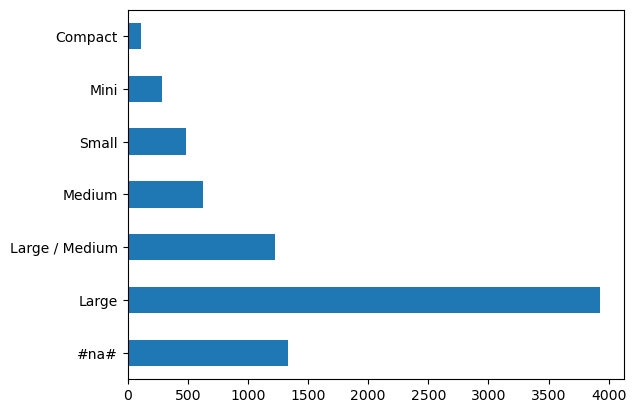

In [99]:
p = valid_xs_final.ProductSize.value_counts(sort=False).plot.barh()
c = to.classes["ProductSize"]
plt.yticks(range(len(c)),c)

Our largest group is Large, but #na# also has \~1250 labels which is the next biggest group.

Lets checkout YearMade

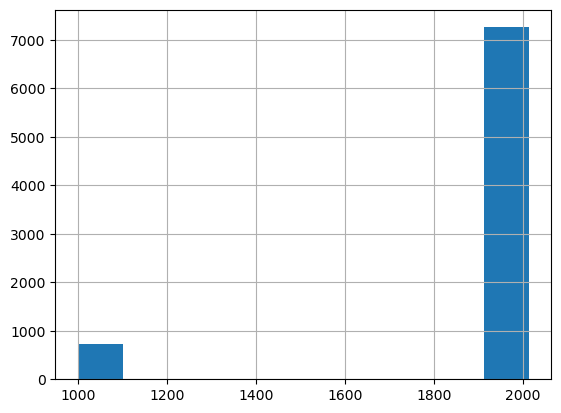

In [100]:
ax = valid_xs_final.YearMade.hist()

My vote for the strangest histogram I've seen in a long time goes to this one, a bunch of year ~1200 models and then the rest in the year 2000?

In [101]:
valid_xs_final.YearMade.describe()

count    7988.000000
mean     1909.009264
std       287.321483
min      1000.000000
25%      1995.000000
50%      2001.000000
75%      2005.000000
max      2013.000000
Name: YearMade, dtype: float64

OK back to partial dependence, the question we want to answer is how much does the sale price change if we change ONLY the year made and leave all else equal. We can't just take the average for any particular feature since lots of other variables change for each observation, instead what we do is lock the value for a particular feature, for example YearMade to 1950, and then predict for all rows the saleprice, and then lock the year to 1951, and so on till we hit the max of our range. This means only the impact of YearMade change has been observed for each prediction and we can see how a particular feature impacts the model's prediction given all else staying equal.

We can then plot each of the years on the x axis and the predictions on the y axis to see the impact of these features

C:\Users\Nick\Anaconda3\envs\fastai\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead


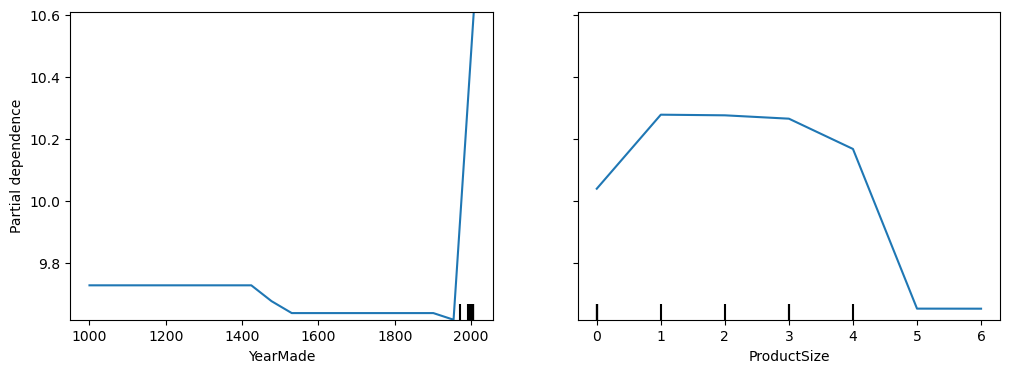

In [102]:
from sklearn.inspection import plot_partial_dependence

fig, ax = plt.subplots(figsize=(12,4))
plot_partial_dependence(tree,
                        valid_xs_final,
                        ["YearMade", "ProductSize"],
                       grid_resolution=20,
                       ax=ax)


Ok my YearMade plot looks extremely different to the book, they have this nice smooth curve from 1960 onwards where it gradually gets more expensive, where as we've got a dead plot flatlining and then absolutely screaming through the roof. I'm not too stressed about fixing up my janky sample as I have the book for reference and I think its actually fun to see stuff blow up and show people, there's too much 'perfect' online of everything being magical and I'm going to leave this here as a nice little mistake. Hopefully you now feel confident to write a better blog than me, tell me how I'm wrong, then I get to learn more, you've shared something fantastic with the world and we net out a better universe than we had before, mistakes are good!

However ProductSize replicates the results from the book nicely and we can see that both the smallest and largest product sizes are detrimental to the sale price, the other important note is the final size is #na# which means the size is missing, which might give us an idea to investigate this particular class as to why this data is missing or whats special about this group. The other thing the book notes is that missing values can sometimes be a good predictor, they can also indicate *data leakage* which is an interesting term, lets learn together.

### Data Leakage

I highly recommend you read the [fastai book](https://github.com/fastai/fastbook/blob/master/09_tabular.ipynb) to read the fantastic sources they reference, I'll do my best to paraphrase data leakage.

From what I gather its where you have accidently 'leaked' some part of your target variable into your training data, for example a model that uses the target as an input. Some real life examples included in the book come from an IBM project where they wanted to predict potential customers for certain products by looking at their website keywords but accidently included websites where potential customers were already customers and they had keywords of already existing IBM products.

Another example is a university predicting successful grant applications, and grants that were missing a particular column were always rejected, this was because the university neglected to fill out this content if the application was rejected, but knowing the grants that did or didn't have this column wouldn't be known at prediction time, so they've accidently leaked the successful grant target signal via the missing value column.

The helpful pointers the book mentions to avoid data leakage are:
 - Accuracy too good to be true is concerning
 - Look for important predictors that make no practical sense
 - Look for partial dependence plot results that don't make sense
 
Lets move on to Tree Interpreters

### Tree Interpreter

In [103]:
from waterfall_chart import plot as waterfall
from treeinterpreter import treeinterpreter

In [104]:
row = valid_xs_final[:5]
prediction, bias, contributions = treeinterpreter.predict(tree, row.values)

In [105]:
prediction[0], bias[0], contributions[0].sum()

(array([10.05627834]), 10.103860252962825, -0.047581913026929705)

Ok we have all our lego bricks, our prediction is our actual prediction, the bias is the prediction based on the mean of the dependent variable, and contributions is the total change in prediction due to the independent variables. This feels very similar to the weight/parameter gradients from our neural net, lets visualise all this

<module 'matplotlib.pyplot' from 'C:\\Users\\Nick\\Anaconda3\\envs\\fastai\\lib\\site-packages\\matplotlib\\pyplot.py'>

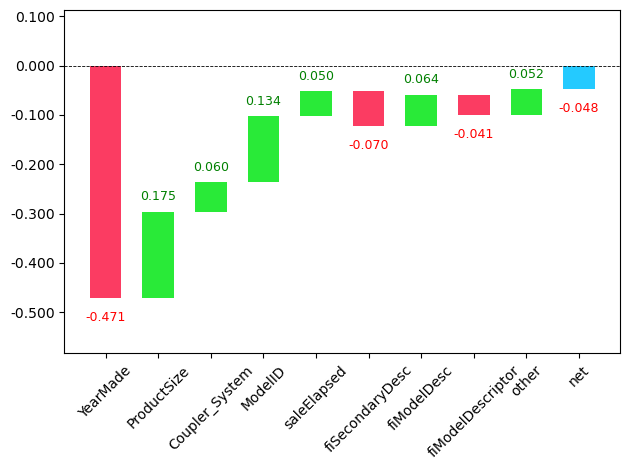

In [106]:
waterfall(valid_xs_final.columns,
         contributions[0],
         threshold=0.08,
         rotation_value=45,
         formatting="{:,.3f}")

This tells us from '0' being the prediction, that YearMade took down our prediction, productsize added to it, coupler_system contributed, and so forth. This helps us see what makes up our predictions, the book notes that this will help production users of the predictions to understand whats influencing the predictions they are consuming.

Now lets talk about extrapolation

### Extrapolation

Extrapolation on new data is always difficult for machine learning as it only learns to approximate the distribution of data that it has seen, however random forests in particular have an extrapolation problem we can visualise

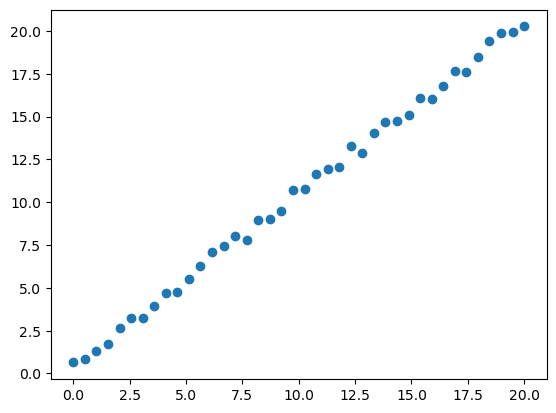

In [107]:
np.random.seed(27)

x_lin = torch.linspace(0,20, steps=40)
y_lin = x_lin + torch.rand_like(x_lin)
plt.scatter(x_lin, y_lin)

Lets now fit a random forest on this data and see how it does

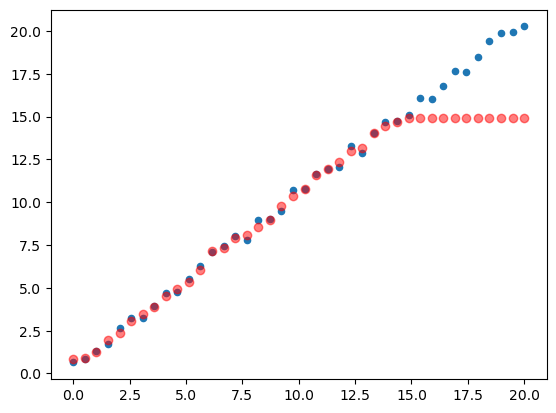

In [108]:
xs_lin = x_lin.unsqueeze(1)
model_lin = RandomForestRegressor().fit(xs_lin[:30],y_lin[:30])
plt.scatter(x_lin, y_lin, 20)
plt.scatter(x_lin, model_lin.predict(xs_lin), color='red', alpha=0.5)

Uh oh, we've flatlined at the top, predictions outside the training data don't do well. This is a concept called "Out-of-Domain" data and trees in particular do horribly at this problem because they are just predicting the average of a group of rows, which will never exceed the rows observed. Lets reference the book and look out how we can detect out of domain data:

### Finding Out of Domain Data

Its tricky to know if your test set is distributed similarly to your training data, the method the book proposes to remedy this is to build a random forest but instead of predicting your dependent variable, you predict whether the observed row is from the validation or training set.

In [109]:
df_dom = pd.concat([xs_final, valid_xs_final])
is_valid = np.array([0]*len(xs_final) + [1]*len(valid_xs_final))

model = random_forest(df_dom, is_valid)
random_forest_feature_importance(model, df_dom)[:6]

,cols,imp
5,saleElapsed,0.899080
11,SalesID,0.086355
14,MachineID,0.011403
16,Tire_Size,0.000561
0,YearMade,0.000439
4,ModelID,0.000347


Ok so saleElapsed is extremely predictive of whether data is in the validation set, as well as SalesID and MachineID. saleElapsed makes sense as we specifically sliced out our validation set based on this variable but SalesID and MachineID being effective prediction signals might mean that these values just increment over time and so they encode the data in a subtle way.

Again with the book, lets build a baseline and see what the effect of removing each column has:

In [110]:
model = random_forest(xs_final, y)
print(f"Original rmse:{model_rmse(model, valid_xs_final, valid_y)}")

for c in ("SalesID","saleElapsed","MachineID"):
    model = random_forest(xs_final.drop(c, axis=1),y)
    print(c, model_rmse(model, valid_xs_final.drop(c, axis=1), valid_y))

Original rmse:0.233341
SalesID 0.230997
saleElapsed 0.234394
MachineID 0.231029


Our performance isn't really changing when we remove these columns, lets try remove them and check the performance

In [111]:
time_variables = ["SalesID", "MachineID"]
xs_final_time = xs_final.drop(time_variables, axis=1)
valid_xs_time = valid_xs_final.drop(time_variables, axis=1)

model = random_forest(xs_final_time, y)
model_rmse(model, valid_xs_time, valid_y)

0.229476

Remarkably the same, maybe slightly lower, in real life this would be an easier model to maintain since there's less used to predict and if the SalesID or MachineID naming systems change, it will have no impact on our model, as you would want it to. The book also discusses just completely removing old data since the relationships in old data just might not be relevant anymore, lets do the same

<AxesSubplot: >

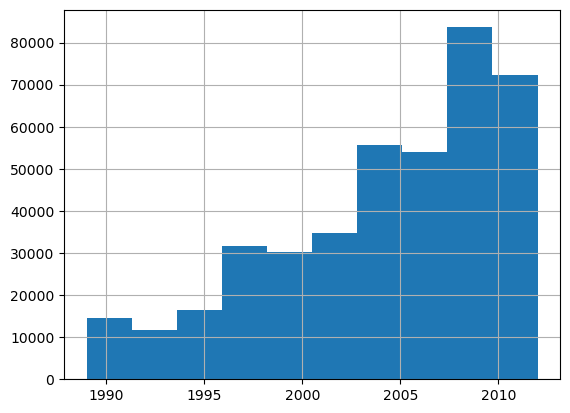

In [112]:
xs.saleYear.hist()

In [113]:
filt = xs.saleYear>2004
xs_filter = xs_final_time[filt]
y_filter = y[filt]

model = random_forest(xs_filter, y_filter)
model_rmse(model, xs_filter, y_filter), model_rmse(model, valid_xs_time, valid_y)

(0.177557, 0.228927)

Wow, cutting out data made our model better by a decent margin.

Lets get onto our old trusty neural nets

### Neural Nets

Lets setup our neural net dataframe using the Procs we established way earlier

In [114]:
df_nn = pd.read_csv(path/"TrainAndValid.csv", low_memory=False)

In [115]:
df_nn.ProductSize = df_nn.ProductSize.astype("category")
df_nn.ProductSize.cat.set_categories(sizes, ordered=True, inplace=True)
df_nn[dependent_variable] = np.log(df_nn[dependent_variable])
df_nn = add_datepart(df_nn, "saledate")

C:\Users\Nick\Anaconda3\envs\fastai\lib\site-packages\pandas\core\arrays\categorical.py:2747: FutureWarning: The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.


In [116]:
df_nn_final = df_nn[list(xs_final_time.columns) + [dependent_variable]]
continous_nn, categorical_nn = cont_cat_split(df_nn_final, max_card=9000, dep_var=dependent_variable)

fastai will build embeddings for us as long as it knows the column is a categorical vairable, it knows this fact by comparing the distinct levels in a feature to the `max_card` (I think this stands for 'maximum cardinality') parameter, if its lower, fastai treats the feature as categorical.

In [117]:
continous_nn

['saleElapsed']

In [118]:
df_nn_final[categorical_nn].nunique()

YearMade                73
ProductSize              6
Coupler_System           2
fiProductClassDesc      74
ModelID               5281
fiSecondaryDesc        177
Hydraulics_Flow          3
fiModelDesc           5059
Enclosure                6
ProductGroup             6
fiModelDescriptor      140
Hydraulics              12
Drive_System             4
Tire_Size               17
dtype: int64

The book notes again that ModelID and fiModelDesc have a similar number of values and its likely they contain redundant and similar information, lets quickly build a forest to see if we can remove it like we did before and do so if we can.

In [119]:
xs_filt2 = xs_filter.drop("fiModelDescriptor", axis=1)
valid_xs_time2 = valid_xs_time.drop("fiModelDescriptor", axis=1)
model2 = random_forest(xs_filt2, y_filter)
model_rmse(model2, xs_filt2, y_filter), model_rmse(model2, valid_xs_time2, valid_y)

(0.176925, 0.229856)

Not a big impact from our prior scores so lets drop it like the book

In [120]:
categorical_nn.remove("fiModelDescriptor")

Lets make our TabularPandas object using the Procs (Processors) we've used before and the normalise proc since neural nets care about scale

In [121]:
procs_nn = [Categorify, FillMissing, Normalize]
to_nn = TabularPandas(df=df_nn_final,
                     procs=procs_nn,
                     cat_names=categorical_nn,
                     cont_names=continous_nn,
                     splits=splits,
                     y_names=dependent_variable)

dls = to_nn.dataloaders(1024)

y = to_nn.train.y
y.min(),y.max()

(8.465899, 11.863583)

For regression models its important to set the y_range so that the model doesn't shoot to high or low

SuggestedLRs(valley=0.00013182566908653826)

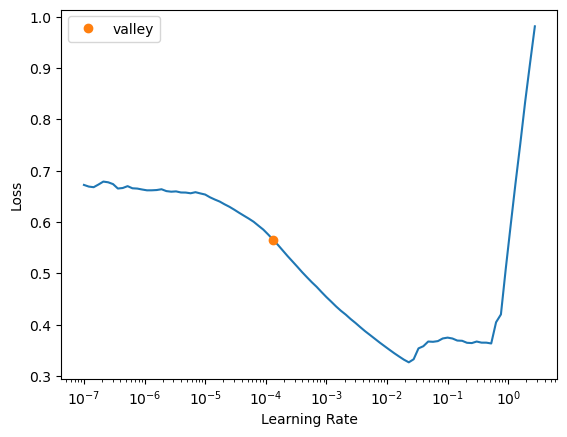

In [122]:
learn = tabular_learner(dls=dls,
                       y_range=(8,12),
                        layers=[500,250],
                        n_out=1,
                        loss_func=F.mse_loss)

learn.lr_find()

In [ ]:
learn.fit_one_cycle(5, 1e-2)

epoch,train_loss,valid_loss,time
0,0.063732,0.061652,00:07
1,0.054273,0.062591,00:07
2,0.047567,0.051852,00:07


In [ ]:
predictions, targets = learn.get_preds()
rmse(predictions, targets)

Its better than our random forest, only using a couple of layers and a few lines of code, woohoo!

### Ensembling

As mentioned before in the bagging section, I really liked the emphasis on the technique rather than its common implementation within trees, as mentioned within the book under the ensembling note, we have two models that we could ensemble together. Considering they are different in construction and error, we could reasonably deduce that the average of their predictions would be better than either one, why don't we try it?

In [ ]:
forest_predictions = model.predict(valid_xs_time)
ensemble_predictions = (to_np(predictions.squeeze()) + forest_predictions) / 2

rmse(ensemble_predictions, valid_y)

And we've reduced our error again from .224 to .221, no extra effort, just averaging, really cool stuff.

The other interesting topic related to bagging is 'boosting' which you may have come across in XGBoost or LightGBM which are both implementations of gradient boosting, lets talk through boosting briefly.

### Boosting

Boosting is where you add models together instead of averaging them, the process goes something like the following:

1. Train a model that underfits
2. Calculate the predictions
3. Subtract the predictions from the targets, these are your 'residuals'
4. Go back to step 1, but use the residuals as targets instead
5. Continue until you reach some stopping point, such as number of trees or validation error increasing (overfit)

Each following tree tries to correct the error of the tree before. To make predictions we calculate the predictions from each tree and then add them together.


### Thanks for the Fish

That was another beast of a week, I want to work through the iteration notebooks but this blog has already blown up in size so I'll post them as separate posts, if you're here reading at the bottom, thankyou! Please let me know any thoughts, feedback, or recommendations you have from what you've read. I'd love to get a signal of people's thoughts on my writing.